In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from collections import Counter
from scipy.stats import shapiro
from scipy.stats import levene
import seaborn as sns
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Performance Functions

In [2]:
def average_precision_at_k_subtype(row, k):
    relevant_count = 0
    precision_sum = 0
    for i in range(1, k+1):
        ret_site = row[f'ret_{i}_diagnosis']
        if ret_site is None:
            continue
        if ret_site == row['query_diagnosis']:
            relevant_count += 1
            precision_sum += relevant_count / i
    if relevant_count == 0:
        return 0
    return precision_sum / min(k, relevant_count)

def majority_voting_at_k_subtype(row, k):
    votes = []
    for i in range(1, k+1):
        ret_site = row[f'ret_{i}_diagnosis']
        if pd.isnull(ret_site):
            votes.append(-1)
        else:
            votes.append(ret_site)
    if not votes:
        return 0
    counter = Counter(votes)
    most_common = counter.most_common(1)
    if most_common[0][0] == row['query_diagnosis']:
        return 1
    elif most_common[0][0] == -1:
        return None
    else:
        return 0

def average_precision_at_k_site(row, k):
    relevant_count = 0
    precision_sum = 0
    for i in range(1, k+1):
        ret_site = row[f'ret_{i}_site']
        if ret_site is None:
            continue
        if ret_site == row['query_site']:
            relevant_count += 1
            precision_sum += relevant_count / i
    if relevant_count == 0:
        return 0
    return precision_sum / min(k, relevant_count)

def majority_voting_at_k_site(row, k):
    votes = []
    for i in range(1, k+1):
        ret_site = row[f'ret_{i}_site']
        if pd.isnull(ret_site):
            votes.append(-1)
        else:
            votes.append(ret_site)
    if not votes:
        return 0
    counter = Counter(votes)
    most_common = counter.most_common(1)
    if most_common[0][0] == row['query_site']:
        return 1
    elif most_common[0][0] == -1:
        return None
    else:
        return 0

# Data Loading

In [3]:
models = ["sish", "hshr", "yottixel", "ablation_yottixel"]

In [4]:
model_dfs = {}
for model in models:
    if model == "ablation_yottixel":
        df_Leica_site = pd.read_csv(f"../../data/yottixel/ABLATION_GBM_MICROSCOPE_CPTAC/site.csv")
        df_Hamamatsu_site = pd.read_csv(f"../../data/yottixel/ABLATION_GBM_MICROSCOPE_UPENN/site.csv")
        
        df_Leica_subtype = pd.read_csv(f"../../data/yottixel/ABLATION_GBM_MICROSCOPE_CPTAC/sub_type.csv")
        df_Hamamatsu_subtype = pd.read_csv(f"../../data/yottixel/ABLATION_GBM_MICROSCOPE_UPENN/sub_type.csv")
    else:
        df_Leica_site = pd.read_csv(f"../../data/{model}/GBM_MICROSCOPE_CPTAC/site.csv")
        df_Hamamatsu_site = pd.read_csv(f"../../data/{model}/GBM_MICROSCOPE_UPENN/site.csv")
        
        df_Leica_subtype = pd.read_csv(f"../../data/{model}/GBM_MICROSCOPE_CPTAC/sub_type.csv")
        df_Hamamatsu_subtype = pd.read_csv(f"../../data/{model}/GBM_MICROSCOPE_UPENN/sub_type.csv")
    
    score_columns_site = []
    for k in [10]:
        df_Leica_site[f'MV_at_{k}_site'] = df_Leica_site.apply(lambda row: majority_voting_at_k_site(row, k), axis=1)
        df_Hamamatsu_site[f'MV_at_{k}_site'] = df_Hamamatsu_site.apply(lambda row: majority_voting_at_k_site(row, k), axis=1)
        score_columns_site.append(f'MV_at_{k}_site')
    
    for k in [5]:
        df_Leica_site[f'AP_at_{k}_site'] = df_Leica_site.apply(lambda row: average_precision_at_k_site(row, k), axis=1)
        df_Hamamatsu_site[f'AP_at_{k}_site'] = df_Hamamatsu_site.apply(lambda row: average_precision_at_k_site(row, k), axis=1)
        score_columns_site.append(f'AP_at_{k}_site')
    
    score_columns_subtype = []
    for k in [5]:
        df_Leica_subtype[f'MV_at_{k}_subtype'] = df_Leica_subtype.apply(lambda row: majority_voting_at_k_subtype(row, k), axis=1)
        df_Hamamatsu_subtype[f'MV_at_{k}_subtype'] = df_Hamamatsu_subtype.apply(lambda row: majority_voting_at_k_subtype(row, k), axis=1)
        score_columns_subtype.append(f'MV_at_{k}_subtype')
    
    for k in [5]:
        df_Leica_subtype[f'AP_at_{k}_subtype'] = df_Leica_subtype.apply(lambda row: average_precision_at_k_subtype(row, k), axis=1)
        df_Hamamatsu_subtype[f'AP_at_{k}_subtype'] = df_Hamamatsu_subtype.apply(lambda row: average_precision_at_k_subtype(row, k), axis=1)
        score_columns_subtype.append(f'AP_at_{k}_subtype')

    dfs = {}
    dfs['df_Leica_site'] = df_Leica_site
    dfs['df_Hamamatsu_site'] = df_Hamamatsu_site
    dfs['df_Leica_subtype'] = df_Leica_subtype
    dfs['df_Hamamatsu_subtype'] = df_Hamamatsu_subtype
    
    model_dfs[model] = dfs

# Bootstrapping

In [5]:
# Function to perform one round of bootstrap sampling and return mean PM of the sample
def bootstrap_mean(df, metric, n):
    sample = df[metric].sample(n=n, replace=True)
    mean_pm = sample.mean()
    return mean_pm

def confidence_interval(bootstrap_differences, confidence=95):
    return np.percentile(bootstrap_differences, [(100 - confidence) / 2, 100 - (100 - confidence) / 2])

def p_value(bootstrap_differences, observed_difference):
    if observed_difference > 0:
        return np.mean([diff < 0 for diff in bootstrap_differences])
    else:
        return np.mean([diff >= 0 for diff in bootstrap_differences])

In [6]:
# Number of bootstrap samples
n_bootstrap = 10000

# Confidence
confidence = 95

In [7]:
results = {}
for model in models:
    results[model] = {}
    
    for metric in ['MV_at_10_site', 'AP_at_5_site']:
        # Original mean PMs
        original_mean_leica = model_dfs[model]['df_Leica_site'][metric].mean()
        original_mean_hamamatsu = model_dfs[model]['df_Hamamatsu_site'][metric].mean()
        observed_difference = original_mean_hamamatsu - original_mean_leica
    
        # Bootstrapping
        bootstrap_differences = []
        for _ in range(n_bootstrap):
            mean_leica = bootstrap_mean(model_dfs[model]['df_Leica_site'], metric, len(model_dfs[model]['df_Leica_site']))
            mean_hamamatsu = bootstrap_mean(model_dfs[model]['df_Hamamatsu_site'], metric, len(model_dfs[model]['df_Hamamatsu_site']))
            difference = mean_hamamatsu - mean_leica
            bootstrap_differences.append(difference)
    
        # Finding Confidence Interval
        ci = confidence_interval(bootstrap_differences, confidence)
        # print(f"confidence interval for {metric}: {ci}")
    
        # Finding p_value
        p = p_value(bootstrap_differences, observed_difference)
        # print(f"P_Value for {metric}: {p}")

        # Saving results
        results[model][metric] = [bootstrap_differences, observed_difference, p, ci]

    for metric in ['MV_at_5_subtype', 'AP_at_5_subtype']:
        # Original mean PMs
        original_mean_leica = df_Leica_subtype[metric].mean()
        original_mean_hamamatsu = df_Hamamatsu_subtype[metric].mean()
        observed_difference = original_mean_hamamatsu - original_mean_leica
    
        # Bootstrapping
        bootstrap_differences = []
        for _ in range(n_bootstrap):
            mean_leica = bootstrap_mean(df_Leica_subtype, metric, len(df_Leica_subtype))
            mean_hamamatsu = bootstrap_mean(df_Hamamatsu_subtype, metric, len(df_Hamamatsu_subtype))
            difference = mean_hamamatsu - mean_leica
            bootstrap_differences.append(difference)
    
        # Finding Confidence Interval
        ci = confidence_interval(bootstrap_differences, confidence)
        # print(f"confidence interval for {metric}: {ci}")
    
        # Finding p_value
        p = p_value(bootstrap_differences, observed_difference)
        # print(f"P_Value for {metric}: {p}")
    
        # Saving results
        results[model][metric] = [bootstrap_differences, observed_difference, p, ci]

# Plots

In [8]:
names_dict = {
    'MV_at_10_site': 'Site MV@10',
    'AP_at_5_site': 'Site AP@5',
    'MV_at_5_subtype': 'Subtype MV@5',
    'AP_at_5_subtype': 'Subtype AP@10',
    'sish': 'SISH',
    'yottixel': 'Yottixel + KimiaNet',
    'ablation_yottixel': 'Yottixel + DenseNet',
    'hshr': 'HSHR',
    'retccl': 'RetCCL',
}

sish and MV_at_10_site:  0.33360 & $[-0.17,  0.27]$ \\
sish and AP_at_5_site:  0.46920 & $[-0.21,  0.19]$ \\
sish and MV_at_5_subtype:  0.03190 & $[-0.46,  0.01]$ \\
sish and AP_at_5_subtype:  0.11040 & $[-0.19,  0.04]$ \\


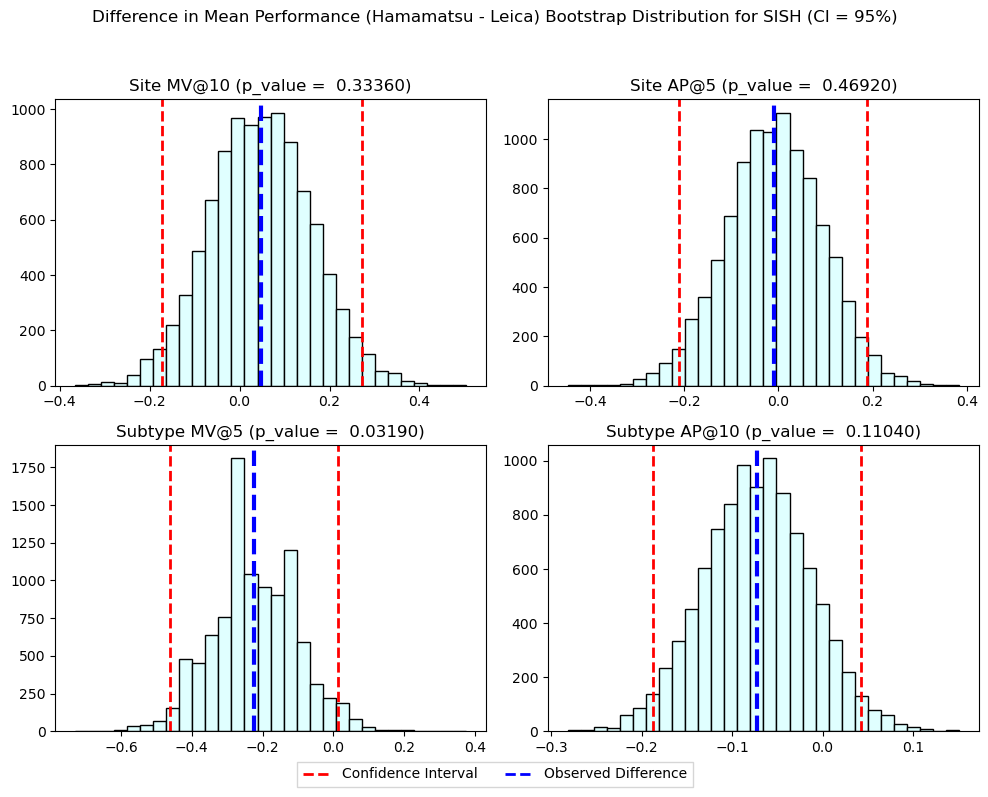

hshr and MV_at_10_site:  0.03420 & $[-0.35,  0.00]$ \\
hshr and AP_at_5_site:  0.49320 & $[-0.14,  0.13]$ \\
hshr and MV_at_5_subtype:  0.03300 & $[-0.46,  0.01]$ \\
hshr and AP_at_5_subtype:  0.10120 & $[-0.19,  0.04]$ \\


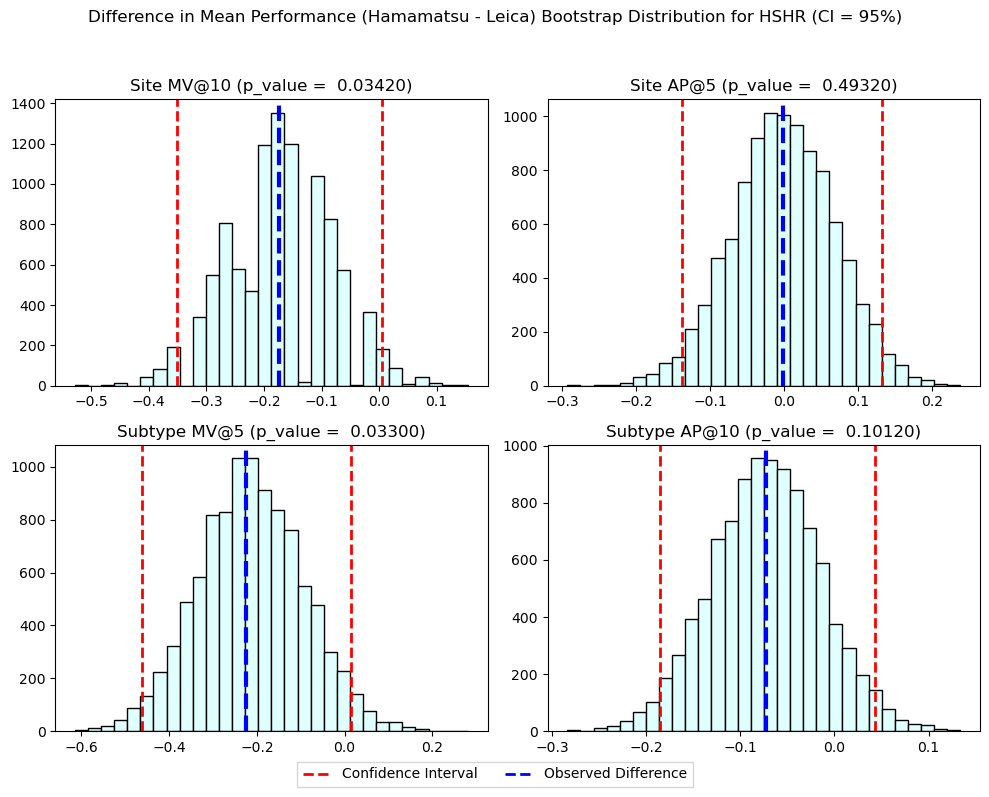

yottixel and MV_at_10_site:  0.24680 & $[-0.14,  0.28]$ \\
yottixel and AP_at_5_site:  0.09760 & $[-0.06,  0.30]$ \\
yottixel and MV_at_5_subtype:  0.03130 & $[-0.46,  0.01]$ \\
yottixel and AP_at_5_subtype:  0.11170 & $[-0.19,  0.04]$ \\


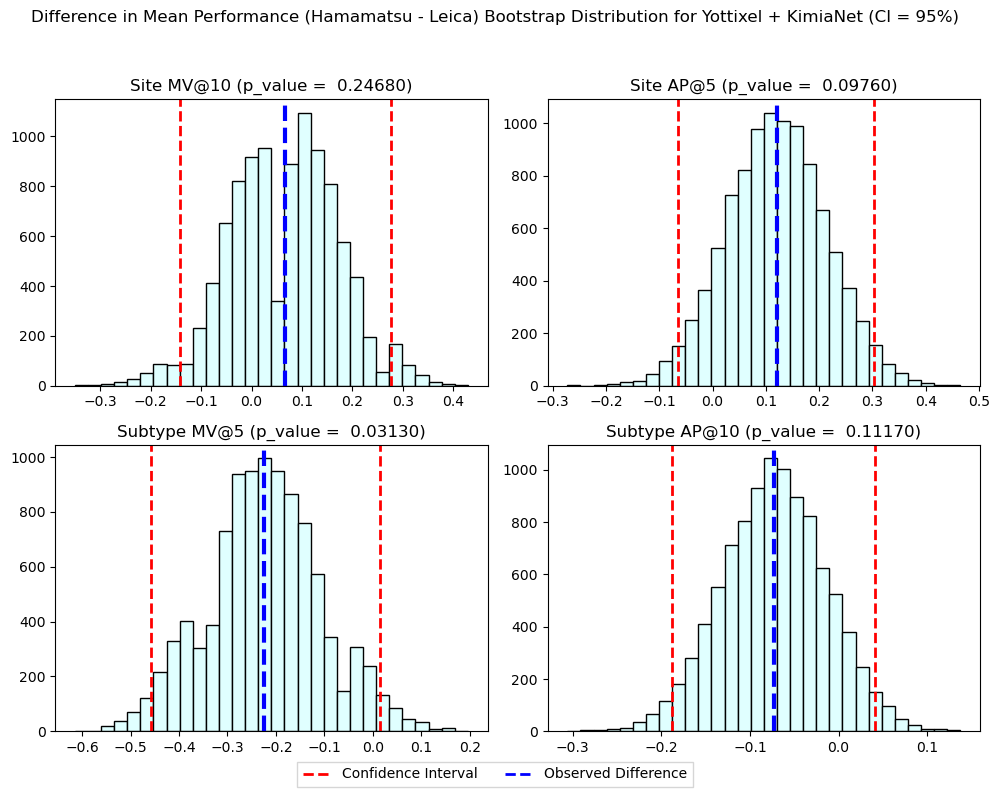

ablation_yottixel and MV_at_10_site:  0.44480 & $[-0.23,  0.25]$ \\
ablation_yottixel and AP_at_5_site:  0.28930 & $[-0.13,  0.23]$ \\
ablation_yottixel and MV_at_5_subtype:  0.03100 & $[-0.46,  0.01]$ \\
ablation_yottixel and AP_at_5_subtype:  0.10460 & $[-0.19,  0.04]$ \\


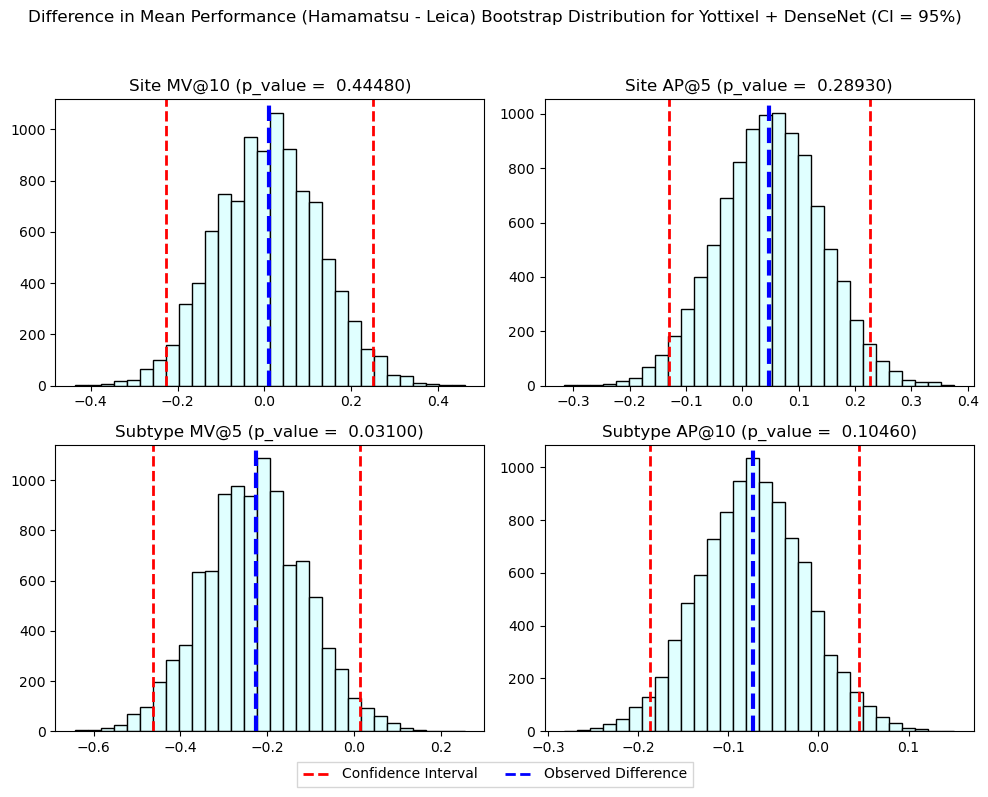

In [9]:
import matplotlib.lines as mlines

# Assuming 'models' and 'results' are defined as in your original code
for model in models:
    # Create a 1x4 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Adjusted figsize for better display
    axs = axs.flatten()  # Flatten the 2x2 matrix into a 1D array for easier indexing

    # Iterate over metrics
    for idx, metric in enumerate(['MV_at_10_site', 'AP_at_5_site', 'MV_at_5_subtype', 'AP_at_5_subtype']):
        bootstrap_differences, observed_difference, p, ci = results[model][metric]
        # Use the axs[idx] for the current subplot
        axs[idx].hist(bootstrap_differences, bins=30, color='lightcyan', edgecolor='black')
        axs[idx].axvline(ci[0], color='red', linestyle='dashed', linewidth=2)
        axs[idx].axvline(ci[1], color='red', linestyle='dashed', linewidth=2)
        axs[idx].axvline(observed_difference, color='blue', linestyle='dashed', linewidth=3)
        axs[idx].set_title(f"{names_dict[metric]} (p_value = {p: .5f})")  # Set title for each subplot

        print(f"{model} and {metric}: {results[model][metric][-2]: .5f} & $[{results[model][metric][-1][0]: .2f}, {results[model][metric][-1][1]: .2f}]$ \\\\")

    # Create custom lines for the legend
    red_line = mlines.Line2D([], [], color='red', linestyle='dashed', linewidth=2, label='Confidence Interval')
    green_line = mlines.Line2D([], [], color='blue', linestyle='dashed', linewidth=2, label='Observed Difference')

    # Add an overall title and adjust layout
    plt.suptitle(f"Difference in Mean Performance (Hamamatsu - Leica) Bootstrap Distribution for {names_dict[model]} (CI = 95%)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjusts the subplots to fit in the figure area
    
    # Add the legend to the figure
    fig.legend(handles=[red_line, green_line], loc='lower center', bbox_to_anchor=(0.5, 0), fancybox=False, shadow=False, ncol=2, frameon=True)
    
    # Save the plot as a PDF file
    plt.savefig(f"microscope_{model}_metrics_plot.pdf", format='pdf')
    
    plt.show()

In [10]:
len(df_Leica_site)

33